# SEAGLE Forward Model 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io
import scipy as scipy
import SEAGLE as seagle
import time

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# %load_ext autoreload
# %reload_ext autoreload



# Lets define the SEAGLE forward model according to the formula in the paper

Basically we want to invert the Lippmann Schwinger equation:

     
$$u(x) = u_{in}+\int_{-\infty}^{\infty} g(x-x^´) f(x^´) u(x^´) \, dx^´$$



Which is equal to a convolution with the Greensfunction with the scattering potential. The Greensfunction in 3D is 
$$ g(x) = \frac{exp(j k_b ||x||^2)}{4\pi||x||^2)} $$ 

where $k_b=\frac{2\pi}{\lambda_0}\sqrt{n_{embb}}$ is the wavenumber in the background medium.


It further reduces to:
$$u(x) = u_{in}+u_{scat}$$

where
$$u_{scat}=\int_{-\infty}^{\infty} g(x-x^´) f(x^´) u(x^´) \, dx^´$$


We can now write the above equation as:


$$u(x) = u_{in}+{F}^{-1}\{{F}\{G\}\times {F}\{f\times u\}\}$$
where $$F\{\},F^{-1}\{\}$$ denote the 3D Fourier- and inverse 3D Fourier-transform respectively. 
We now assume, that the input field $u_{in}$ is known and try to minimize the following problem with respect to $u$:

$$min_{\rightarrow u} \left( u(x) - u_{in} - {F}^{-1}\{{F}\{G\}\times {F}\{f\times u\}\}\right)$$


As an object $f(x)$ we insert the 3D refractive index distribution as follows:

$$f(x) = k^2(n_{obj}(x)-n_{embbb})$$
which is assumed to be real, where the wavenumber in vacuum is given by $k=\frac{2 \pi }{\lambda_0}$.

# Define experimental Parameters

In [2]:
#%---------------------------------------------------------------------
#                  START CODE HERE                                    #
#%---------------------------------------------------------------------
       
# Define some parameters
is_debug = True # do you want to display everything?
learningrate = .1 
Niter = 40 # Optimization Steps

mysize = (100, 100, 100) # Z X Y
mymidpoint = int(mysize[1]/2)
mysample = np.zeros(mysize)

nObj = 1.4
nEmbb = 1.33
#nObj = 1.52 + 0.0 * 1j;
Boundary=9;

lambda0 = .5; # measured in µm
pixelsize = lambda0/4


# generate Sample, Assume nObj everywhere where mysample is 1, rest is background 
mysample = seagle.insertSphere((mysample.shape[0], mysample.shape[1], mysample.shape[2]), obj_dim=0.1, obj_type=0, diameter=1, dn=1) 

# define the source and insert it in the volume
kx = 0
ky = 0
myWidth = 20;
mySrc = seagle.insertSrc(mysize, myWidth, myOff=(Boundary+1, 0, 0), kx=kx,ky=ky);

# Initialize the SEAGLE model

Now computing Greens function and its fourier transformed
# What is the correct factor and why?


/Users/bene/Dropbox/Dokumente/Promotion/PROJECTS/BOSTON/SEAGLE/PYTHON/TF_MetaSEAGLE/SEAGLE.py:429: RuntimeWarning: divide by zero encountered in true_divide
  self.greens_fkt = np.exp((1j*self.kb)*np.abs(self.kr))/np.abs(4*np.pi*self.kr)
/Users/bene/Dropbox/Dokumente/Promotion/PROJECTS/BOSTON/SEAGLE/PYTHON/TF_MetaSEAGLE/SEAGLE.py:429: RuntimeWarning: invalid value encountered in true_divide
  self.greens_fkt = np.exp((1j*self.kb)*np.abs(self.kr))/np.abs(4*np.pi*self.kr)


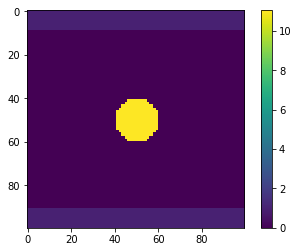

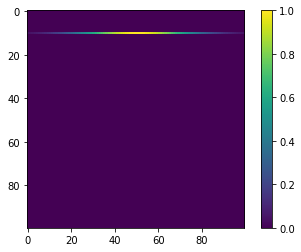

Initialize the SEAGLE System


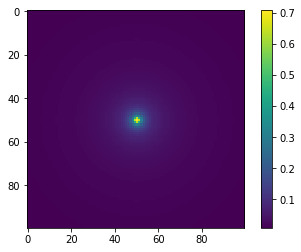

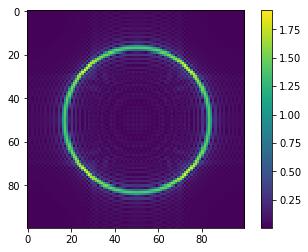

Define Cost-Function and Optimizer
Init operands 
run init


In [3]:
#%-----------------------------------------------------------------------------
#                  SEAGLE PART COMES  HERE                                    #
#%-----------------------------------------------------------------------------

# Instantiate the SEAGLE
MySEAGLE = seagle.SEAGLE(mysample, mySrc, lambda0=lambda0, pixelsize=pixelsize, nObj = nObj, nEmbb=nEmbb, Boundary=Boundary)

if(is_debug):
    # displaying the Src and Obj just for debugging purposes
    plt.imshow(np.squeeze(np.real(MySEAGLE.f[:,:,np.int(np.floor(mysize[2]/2))]))), plt.colorbar(), plt.show()
    plt.imshow(np.squeeze(np.real(MySEAGLE.mySrc[:,:,np.int(np.floor(mysize[2]/2))]))), plt.colorbar(), plt.show()
    
    scipy.io.savemat('myobj.mat', mdict={'myobj': MySEAGLE.f})
    scipy.io.savemat('myrsc.mat', mdict={'mySrc': MySEAGLE.mySrc})



# Compute the model inside the convergent born series 
MySEAGLE.computeModel()

if(is_debug):
    # Visualize Greenzs function
    plt.imshow(np.abs(MySEAGLE.greens_fkt[:,:,mymidpoint])), plt.colorbar(), plt.show()
    plt.imshow(np.abs(MySEAGLE.greens_fkt_ft[:,:,mymidpoint])), plt.colorbar(), plt.show()


# Define Minimization step
MySEAGLE.minimize(learningrate)

# Initialize all operands
MySEAGLE.compileGraph()


# Start to compute the E-field by minimizing the error of Lippmann-Schwinger

Start Computing the result
Step 0 took 0.0 s and the error: 0.0001115493


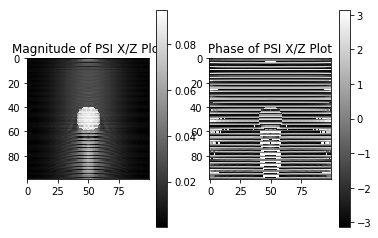

Step 1 took 0.0 s and the error: 0.0010053132
Step 2 took 0.0 s and the error: 6.169624e-05
Step 3 took 0.0 s and the error: 0.00037357848
Step 4 took 0.0 s and the error: 0.00050351466
Step 5 took 0.0 s and the error: 0.00014438361
Step 6 took 0.0 s and the error: 4.7929065e-05
Step 7 took 0.0 s and the error: 0.00024900626
Step 8 took 0.0 s and the error: 0.00028609496
Step 9 took 0.0 s and the error: 0.00011216446
Step 10 took 0.0 s and the error: 2.0374e-05


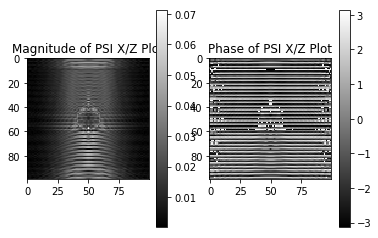

Step 11 took 0.0 s and the error: 0.000107417036
Step 12 took 0.0 s and the error: 0.0001835176
Step 13 took 0.0 s and the error: 0.00012072385
Step 14 took 0.0 s and the error: 2.6896189e-05
Step 15 took 0.0 s and the error: 2.9776913e-05
Step 16 took 0.0 s and the error: 9.3850256e-05
Step 17 took 0.0 s and the error: 0.00010423857
Step 18 took 0.0 s and the error: 4.8375485e-05
Step 19 took 0.0 s and the error: 1.0869642e-05
Step 20 took 0.0 s and the error: 3.3934746e-05


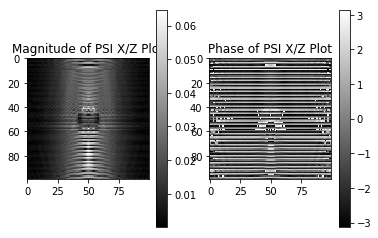

Step 21 took 0.0 s and the error: 6.618472e-05
Step 22 took 0.0 s and the error: 5.3625266e-05
Step 23 took 0.0 s and the error: 1.7952332e-05
Step 24 took 0.0 s and the error: 9.941753e-06
Step 25 took 0.0 s and the error: 3.1395255e-05
Step 26 took 0.0 s and the error: 4.155576e-05
Step 27 took 0.0 s and the error: 2.40638e-05
Step 28 took 0.0 s and the error: 6.465208e-06
Step 29 took 0.0 s and the error: 1.1766676e-05
Step 30 took 0.0 s and the error: 2.5252155e-05


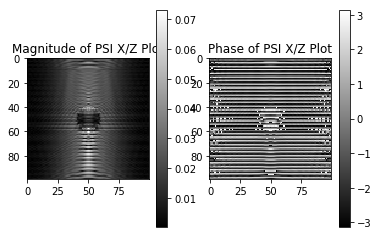

Step 31 took 0.0 s and the error: 2.2609665e-05
Step 32 took 0.0 s and the error: 8.293307e-06
Step 33 took 0.0 s and the error: 4.1277244e-06
Step 34 took 0.0 s and the error: 1.3179914e-05
Step 35 took 0.0 s and the error: 1.7335138e-05
Step 36 took 0.0 s and the error: 8.903916e-06
Step 37 took 0.0 s and the error: 1.978952e-06
Step 38 took 0.0 s and the error: 6.4633064e-06
Step 39 took 0.0 s and the error: 1.1889101e-05


In [4]:
#%% Do n iterations to let the series converge
print('Start Computing the result')
for i in range(Niter):

    start_time = time.time()
    _, myerror = MySEAGLE.sess.run([MySEAGLE.train_op, MySEAGLE.my_error])
    print('Step '+str(i) + ' took ' +str(0*(time.time()-start_time))+' s'+ ' and the error: '+str(myerror))
    if(np.mod(i,10)==0 and is_debug):
        #%% Display result 
        plt.subplot(1,2,1), plt.title('Magnitude of PSI X/Z Plot')
        plt.imshow(np.squeeze(np.abs(MySEAGLE.tf_u.eval()[:,mymidpoint,:])), cmap='gray'), plt.colorbar()
        plt.subplot(1,2,2), plt.title('Phase of PSI X/Z Plot')
        plt.imshow(np.squeeze(np.angle(MySEAGLE.tf_u.eval()[:,mymidpoint,:])), cmap='gray'), plt.colorbar()
        plt.show()

# Visualize and Save results

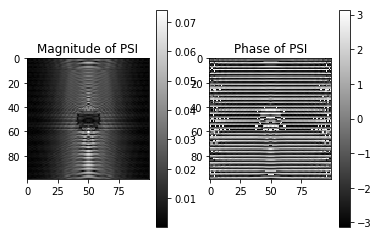

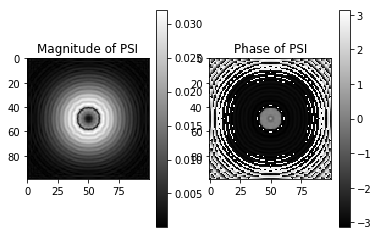

SERIOUS PROBLEM!!!! Why is the FT of Green so weird?


In [5]:
#%% Display result 
plt.subplot(1,2,1), plt.title('Magnitude of PSI')
plt.imshow(np.squeeze(np.abs(MySEAGLE.tf_u.eval()[:,:,mymidpoint ])), cmap='gray'), plt.colorbar()
plt.subplot(1,2,2), plt.title('Phase of PSI')
plt.imshow(np.squeeze(np.angle(MySEAGLE.tf_u.eval()[:,:,mymidpoint ])), cmap='gray'), plt.colorbar()
plt.show()

# Display result 
plt.subplot(1,2,1), plt.title('Magnitude of PSI')
plt.imshow(np.squeeze(np.abs(MySEAGLE.tf_u.eval()[mymidpoint,:,:])), cmap='gray'), plt.colorbar()
plt.subplot(1,2,2), plt.title('Phase of PSI')
plt.imshow(np.squeeze(np.angle(MySEAGLE.tf_u.eval()[mymidpoint,:,:])), cmap='gray'), plt.colorbar()
plt.show()
print('SERIOUS PROBLEM!!!! Why is the FT of Green so weird?')


scipy.io.savemat('exportresult.mat', mdict={'u_dash': MySEAGLE.tf_u.eval(), 
                                            'f_obj':MySEAGLE.f, 
                                            'mysrc': MySEAGLE.mySrc, 
                                            'u_in': MySEAGLE.u_in, 
                                            'greens_fkt': MySEAGLE.greens_fkt, 
                                            'greens_fkt_ft': MySEAGLE.greens_fkt_ft})

# save images
myamp_res = np.squeeze(np.abs(MySEAGLE.tf_u.eval()[mymidpoint,:,:]))
myamp_res  = np.uint8(myamp_res /np.max(myamp_res )*(2**8-1))
plt.imsave('result_abs_xy.png', myamp_res)

myphase_res = np.squeeze(np.angle(MySEAGLE.tf_u.eval()[mymidpoint,:,:]))
myphase_res = np.uint8(myphase_res/np.max(myphase_res)*(2**8-1))
plt.imsave('result_angle_xy.png', myphase_res)


myamp_res = np.squeeze(np.abs(MySEAGLE.tf_u.eval()[:,mymidpoint,:]))
myamp_res  = np.uint8(myamp_res /np.max(myamp_res )*(2**8-1))
plt.imsave('result_abs_xz.png', myamp_res)

myphase_res = np.squeeze(np.angle(MySEAGLE.tf_u.eval()[:,mymidpoint,:]))
myphase_res = np.uint8(myphase_res/np.max(myphase_res)*(2**8-1))
plt.imsave('result_angle_xz.png', myphase_res)